# VibeQ – DeBERTa student fine-tune

## Environment setup
Install transformer stack for training.

In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00


In [2]:
!pip install -U transformers datasets accelerate evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Imports

In [4]:
import numpy as np
import torch
from torch import nn

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.metrics import f1_score
import random
import os


## Reproducibility

In [5]:
import os, random
import numpy as np
import torch

SEED = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# Your target 9 labels (fixed order!)
TARGET_LABELS = ["anger","anticipation","caring","disgust","fear","joy","neutral","sadness","surprise"]
label2id = {l:i for i,l in enumerate(TARGET_LABELS)}
id2label = {i:l for l,i in label2id.items()}
NUM_LABELS = len(TARGET_LABELS)

# Use your best multi-label checkpoint as the "base encoder"
BASE_CKPT = "/content/drive/MyDrive/VibeQ-EIE/models/HF_deberta_goemotions_focal_v1_9emmotions"

# Where to save this new single-label student
SAVE_DIR = "/content/drive/MyDrive/VibeQ-EIE/models/student_singlelabel_9emotions_v1"
os.makedirs(SAVE_DIR, exist_ok=True)

MAX_LENGTH = 192


## Load GoEmotions dataset

In [6]:
from datasets import load_dataset

dataset = load_dataset("go_emotions", "simplified")

# remove unclear if exists
for split in ["train","validation","test"]:
    if "example_very_unclear" in dataset[split].column_names:
        dataset[split] = dataset[split].filter(lambda x: x["example_very_unclear"] == 0)

original_labels = dataset["train"].features["labels"].feature.names
orig_id2label = {i: name for i, name in enumerate(original_labels)}

EMOTION_MAP = {
    "anger": "anger", "annoyance": "anger", "disapproval": "anger",
    "optimism": "anticipation", "curiosity": "anticipation", "desire": "anticipation",
    "caring": "caring", "love": "caring", "admiration": "caring", "gratitude": "caring", "approval": "caring",
    "disgust": "disgust",
    "fear": "fear", "nervousness": "fear",
    "joy": "joy", "excitement": "joy", "amusement": "joy", "pride": "joy", "relief": "joy",
    "neutral": "neutral",
    "sadness": "sadness", "disappointment": "sadness", "grief": "sadness", "remorse": "sadness", "embarrassment": "sadness",
    "surprise": "surprise", "confusion": "surprise", "realization": "surprise",
}

def map_to_single_label(example):
    # example["labels"] is list[int] of original label ids
    mapped = []
    for old_idx in example["labels"]:
        name = orig_id2label[old_idx]
        if name in EMOTION_MAP:
            mapped.append(EMOTION_MAP[name])

    if len(mapped) == 0:
        return {"label": -1}  # will filter out

    # deterministic choice for single-label:
    # priority: if neutral present -> neutral, else first mapped (stable)
    if "neutral" in mapped:
        chosen = "neutral"
    else:
        chosen = mapped[0]

    return {"label": label2id[chosen]}

dataset = dataset.map(map_to_single_label)

# filter out any rows that couldn't be mapped
for split in ["train","validation","test"]:
    dataset[split] = dataset[split].filter(lambda x: x["label"] != -1)

dataset


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id', 'label'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id', 'label'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id', 'label'],
        num_rows: 5427
    })
})

## Tokenization

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    BASE_CKPT,
    fix_mistral_regex=True
)


def tokenize(example):
    enc = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    enc["labels"] = int(example["label"])   # Trainer expects "labels"
    return enc

encoded = dataset.map(tokenize, remove_columns=[c for c in dataset["train"].column_names if c not in ["text","labels","label"]])
encoded.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

train_ds = encoded["train"]
val_ds   = encoded["validation"]
test_ds  = encoded["test"]

len(train_ds), len(val_ds), len(test_ds)



Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

(43410, 5426, 5427)

## Initialize model

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    BASE_CKPT,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True  # replaces old head
)

# Quick sanity prints
print("Loaded model:", type(model).__name__)
print("num_labels:", model.config.num_labels)


Loaded model: DebertaV2ForSequenceClassification
num_labels: 9


## Metrics

In [9]:
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
    }


## Train head only

In [10]:
from transformers import TrainingArguments, Trainer

# freeze encoder (deberta)
for p in model.deberta.parameters():
    p.requires_grad = False

args_head = TrainingArguments(
    output_dir="/content/results_student_head_only",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.1,
    max_grad_norm=1.0,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=args_head,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()



/tmp/ipython-input-2633062846.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,1.028500,1.066959,0.572678,0.635827


{'eval_loss': 1.0669591426849365,
 'eval_f1_macro': 0.572677819510911,
 'eval_f1_micro': 0.6358274972355327,
 'eval_runtime': 47.0335,
 'eval_samples_per_second': 115.365,
 'eval_steps_per_second': 3.614,
 'epoch': 1.0}

## Unfreeze and full fine-tune

In [11]:
for p in model.deberta.parameters():
    p.requires_grad = True

args_full = TrainingArguments(
    output_dir="/content/results_student_full_ft",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    warmup_ratio=0.1,
    max_grad_norm=1.0,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=100,
    save_total_limit=2,
    report_to="none",
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=args_full,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate()


/tmp/ipython-input-4001676556.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Micro
1,0.707100,1.127931,0.590307,0.646885
2,0.380000,1.455398,0.580433,0.637302


{'eval_loss': 1.1279306411743164,
 'eval_f1_macro': 0.5903070105076325,
 'eval_f1_micro': 0.6468853667526723,
 'eval_runtime': 46.8927,
 'eval_samples_per_second': 115.711,
 'eval_steps_per_second': 3.625,
 'epoch': 2.0}

## Evaluate test split

In [12]:
test_metrics = trainer.evaluate(test_ds)
test_metrics


{'eval_loss': 1.1377006769180298,
 'eval_f1_macro': 0.5868752088011234,
 'eval_f1_micro': 0.6368159203980099,
 'eval_runtime': 46.6919,
 'eval_samples_per_second': 116.23,
 'eval_steps_per_second': 3.641,
 'epoch': 2.0}

## Save checkpoint

In [13]:
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Saved to:", SAVE_DIR)


Saved to: /content/drive/MyDrive/VibeQ-EIE/models/student_singlelabel_9emotions_v1


## Reload and quick sanity check

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Test F1 Macro: 0.5864110586344824
Test F1 Micro: 0.6333149069467477

Classification Report:

              precision    recall  f1-score   support

       anger      0.550     0.556     0.553       703
anticipation      0.536     0.487     0.510       427
      caring      0.755     0.733     0.744      1393
     disgust      0.500     0.488     0.494        84
        fear      0.704     0.633     0.667        90
         joy      0.703     0.683     0.693       467
     neutral      0.600     0.691     0.643      1606
     sadness      0.580     0.593     0.587       317
    surprise      0.548     0.300     0.388       340

    accuracy                          0.633      5427
   macro avg      0.608     0.574     0.586      5427
weighted avg      0.633     0.633     0.630      5427



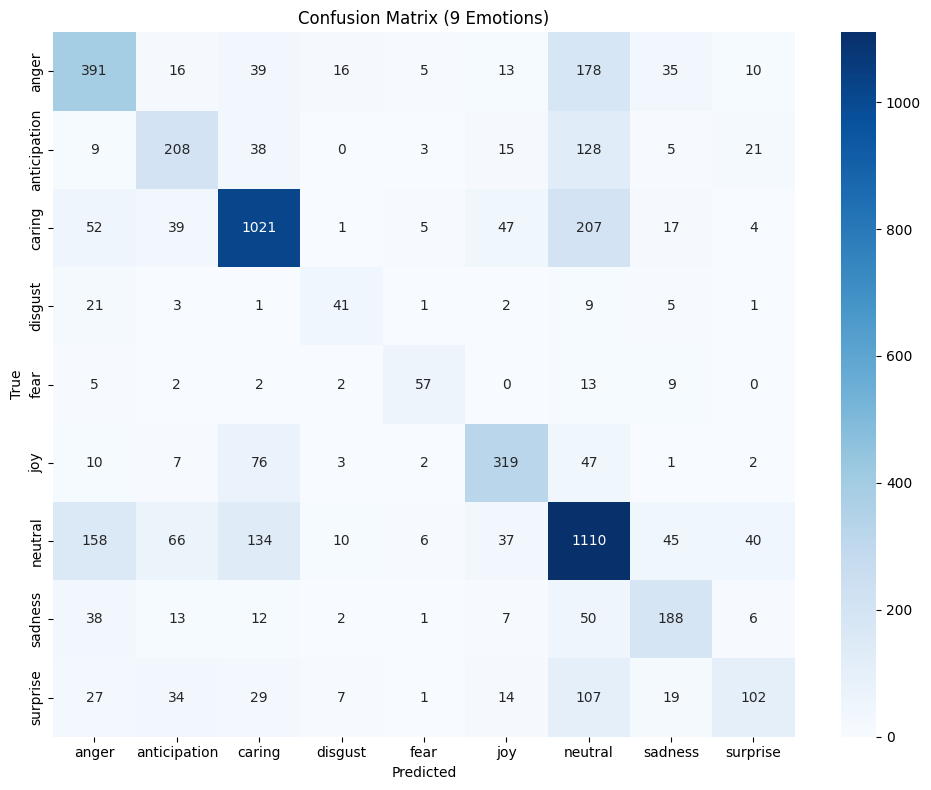

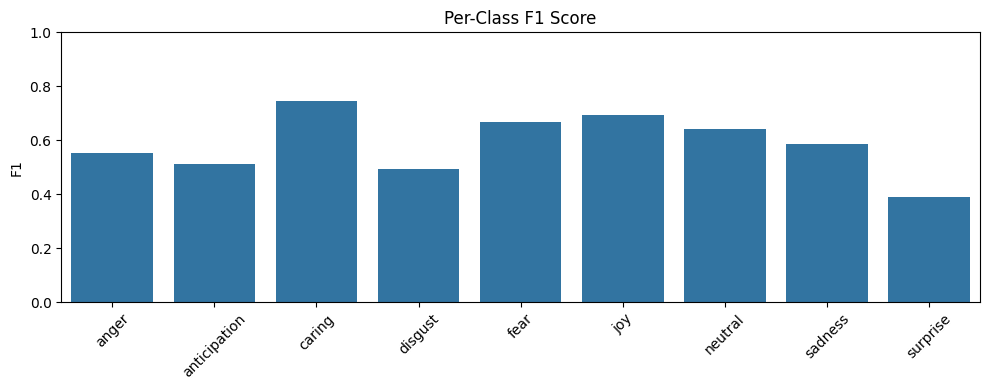

In [8]:
# ===============================
# Load model + tokenizer
# ===============================
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)

MODEL_PATH = "/content/drive/MyDrive/VibeQ-EIE/models/student_singlelabel_9emotions_v1"
MAX_LENGTH = 192

TARGET_LABELS = [
    "anger", "anticipation", "caring", "disgust", "fear",
    "joy", "neutral", "sadness", "surprise"
]

EMOTION_MAP = {
    "anger": "anger", "annoyance": "anger", "disapproval": "anger",
    "optimism": "anticipation", "curiosity": "anticipation", "desire": "anticipation",
    "caring": "caring", "love": "caring", "admiration": "caring", "gratitude": "caring", "approval": "caring",
    "disgust": "disgust",
    "fear": "fear", "nervousness": "fear",
    "joy": "joy", "excitement": "joy", "amusement": "joy", "pride": "joy", "relief": "joy",
    "neutral": "neutral",
    "sadness": "sadness", "disappointment": "sadness", "grief": "sadness", "remorse": "sadness", "embarrassment": "sadness",
    "surprise": "surprise", "confusion": "surprise", "realization": "surprise",
}

label2id = {l: i for i, l in enumerate(TARGET_LABELS)}
id2label = {i: l for l, i in label2id.items()}

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# ===============================
# Load dataset + preprocessing
# ===============================
dataset = load_dataset("go_emotions", "simplified")

def map_to_9(batch):
    tokenized = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    labels = []
    for labs in batch["labels"]:
        mapped = None
        for l in labs:
            name = dataset["train"].features["labels"].feature.names[l]
            if name in EMOTION_MAP:
                mapped = label2id[EMOTION_MAP[name]]
                break
        labels.append(mapped if mapped is not None else label2id["neutral"])
    tokenized["labels"] = labels
    return tokenized

encoded = dataset.map(
    map_to_9,
    batched=True,
    remove_columns=dataset["train"].column_names
)
encoded.set_format("torch")

test_ds = encoded["test"]

# ===============================
# Run predictions
# ===============================
trainer = Trainer(model=model)
pred_output = trainer.predict(test_ds)

logits = pred_output.predictions
y_true = pred_output.label_ids
y_pred = logits.argmax(axis=1)

# ===============================
# Metrics
# ===============================
print("Test F1 Macro:", f1_score(y_true, y_pred, average="macro"))
print("Test F1 Micro:", f1_score(y_true, y_pred, average="micro"))

print("\nClassification Report:\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=TARGET_LABELS,
        digits=3
    )
)

# ===============================
# Confusion Matrix
# ===============================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    xticklabels=TARGET_LABELS,
    yticklabels=TARGET_LABELS,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix (9 Emotions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ===============================
# Per-class F1 Bar Chart
# ===============================
report = classification_report(
    y_true,
    y_pred,
    target_names=TARGET_LABELS,
    output_dict=True
)

f1s = [report[l]["f1-score"] for l in TARGET_LABELS]

plt.figure(figsize=(10, 4))
sns.barplot(x=TARGET_LABELS, y=f1s)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.title("Per-Class F1 Score")
plt.ylabel("F1")
plt.tight_layout()
plt.show()
